In [1]:
# General imports
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import normalized_mutual_info_score 
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

#### Import Data

In [2]:
#####################
# KDD Dataset
# First column is the BLOCK ID (class label), BLOCK IDs are integers running from 1 to 303 with 153 unique values (k)
# Second column is the ELEMENT ID (sample number), unique numbers, not ordered
# Third column is the class of the example. Homologous proteins = 1, non-homologous proteins = 0
data = pd.read_csv('bio_train.csv',skiprows=0).to_numpy(dtype='object')

#####################
# Toy Dataset
toy_data = np.genfromtxt('dataset1_noCluster7.csv', delimiter = ',')[1:]
toy_data_features = toy_data[:,:2]
toy_data_labels = toy_data[:,-1]

scaler = StandardScaler()
toy_data_features = scaler.fit_transform(toy_data_features)

#plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_data_labels)
#plt.show()

#### Data Preprocessing

In [3]:
# Shuffle, split into labels/features and normalize data
def process_data(data):
    # Shuffle
    shuffle = np.random.permutation(len(data))
    data = data[shuffle]
    
    # Split
    block_ids = data[:,0]
    element_ids = data[:,1]
    homology = data[:,2]
    features = data[:,3:]
    
    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    return block_ids, element_ids, features

In [4]:
# preprocess the data
block_ids, element_ids, features = process_data(data)
features = features.astype(np.float64) # only important if no normalization is done

### Task 1 - Lloyds Algorithm

In [5]:
def lloyds(data, k=153):
    # Number of samples and features of the dataset
    
    n_samples, n_features = np.shape(data)
    
    # Pick k random points from data to be the initial cluster centers (eventually use kmeans+ here?)
    #rand_nums = np.random.randint(0,n_samples,k)
    #cluster_means = data[rand_nums]
    
    # pick the first k points as initial cluster means
    cluster_means = np.copy(data[:k])
    
    
    #kmeans++
    #cluster_means = kmeans_plus_initialization(data, k)
    
    old_means = np.zeros([k, n_features])
    counter = 0
    
    while (old_means != cluster_means).any():
    
        counter += 1
        old_means = np.copy(cluster_means)
        
        # avoiding endless loop
        if counter == 1000:
            break
            
        # printing progress
        if counter % 20 == 0: 
            print("iteration: ",counter)

            
        # measure assingment runtime
        #start_assign = time.perf_counter()
        
        ############# Assign step
        
        distance_matrix = cdist(data,cluster_means, metric='sqeuclidean')
        cluster_labels = np.argmin(distance_matrix, axis=1)
        
        ############# Update step
        for j in range(k):
            
            idcs = np.where(cluster_labels == j)[0]
            cluster_size = len(idcs)
            
            if cluster_size > 0:
                cluster_sum = np.sum(data[idcs], axis=0)
                cluster_means[j] = cluster_sum/cluster_size
            
            
        #end_update = time.perf_counter()
        
        #print('Assign step runtime: '+str(start_update - start_assign))
        #print('Update step runtime: '+str(end_update - start_update))
        
    print('KMeans converged in '+str(counter)+' iterations.')
    return cluster_labels, cluster_means


def kmeans_plus_initialization(data, k):
    no_samples = len(data)
    
    cluster_means = np.zeros((k,len(data[0])))
    cluster_means[0] = data[np.random.randint(0,no_samples)]
    
    for i in range(1,k):
        distances = cdist(data,cluster_means, metric='sqeuclidean')
        idx = np.argmax(np.min(distances, axis = 1))
        cluster_means[i] = data[idx]

    return cluster_means

In [6]:
# clustering the KDD Dataset
labels, centers = lloyds(features)

KeyboardInterrupt: 

In [ ]:
NMI_score = normalized_mutual_info_score(block_ids, labels)
print(NMI_score)

iteration:  20
KMeans converged in 21 iterations.
0.8418833655707196


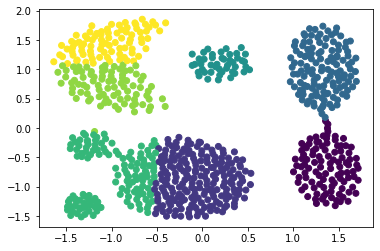

In [7]:
# run algorithm with the toy dataset
toy_labels, toy_centers = lloyds(toy_data_features, k=7)

NMI_score = normalized_mutual_info_score(toy_data_labels, toy_labels)
print(NMI_score)

plt.scatter(toy_data_features[:,0], toy_data_features[:,1], c = toy_labels)
plt.show()

### Task 2 - LSH + Kmeans

In [8]:
# This class defines a given number of hash functions. 
# The calculate_hash_values function can be used to calclueate the hash values of any array with no_features as the second dimension

# not finished, just playing around, hello Jakob

class hash_functions:
    def __init__(self, no_functions, no_buckets, no_features):
        self.no_functions = no_functions
        self.no_buckets = no_buckets
        self.no_features = no_features
        
        self.b = np.zeros(no_functions) # vector
        self.a = np.random.normal(loc=0.0, scale=1.0, size=(no_features, no_functions)) # matrix

    def sample_hash_values(self, data):
        
        self.w = []
        
        hash_values = np.dot(data, self.a) + self.b
        
        # This for loop goes over each column of the hash_values (each hash function) and computes 
        # the bucket size (w) for the given no_buckets parameter; thereafter it uses these values
        # to complete the (a*p + b)/w hash values definition
        
        # w has to be known apriori and is only possible to derive using part of the actual hashing process
        # a more visually pleasing version of this would be to calculate w using data during the initialization
        # and use one single hashing function for both samples and clusters, but then we have to recompute a 
        # lot of calculation in the hashing - namely (a*p + b), which is used in the w computation
        
        for i in range(self.no_functions):
            min_val = np.min(hash_values[:,i])
            max_val = np.max(hash_values[:,i])
            self.w.append((max_val-min_val)/(self.no_buckets - 1))
            hash_values[:,i] = np.floor(hash_values[:,i]/self.w[i])
        
        return hash_values
    
    def cluster_hash_values(self, data):
        return np.floor((np.dot(data, self.a) + self.b) / self.w)
        

In [25]:
# define hash functions
no_features = len(features[0])
no_buckets = 10
hash_funcs = hash_functions(4, no_buckets, no_features)

#calculate the 16 hash values from all features
hash_values = hash_funcs.sample_hash_values(features)

#print(hash_values)
"""
# pick the first k points as initial cluster means
cluster_means = data[:k]
old_means = np.zeros([k, n_features])
counter = 0

while (old_means != cluster_means).any():
    
    counter += 1
    old_means = np.copy(cluster_means)
    
    # calculate hash values of the cluster centers
    cluster_means_hashes = hash_funcs.calculate_hash_values(cluster_means)
    
    # link the hash values with AND and OR to form the final buckets
    
"""
print(hash_values)  
c_values = hash_funcs.cluster_hash_values(features[:2])
print(c_values)

[[ 0. -1. -1. -1.]
 [-1. -1.  0. -1.]
 [-1.  0. -1. -1.]
 ...
 [ 0. -1.  0. -1.]
 [-1.  0.  0.  0.]
 [ 0. -1. -1. -1.]]
[[ 0. -1. -1. -1.]
 [-1. -1.  0. -1.]]


In [24]:
# WORK IN PROGRESS

def lloyds_LSH(data, k=153, no_functions=4, no_buckets=10):
    # Number of samples and features of the dataset
    n_samples, n_features = np.shape(data)
    
    # Pick the first k points as initial cluster means
    cluster_means = np.copy(data[:k])

    # Initialize hash functions
    hash_funcs = hash_functions(no_functions, no_buckets, n_features)
    
    # Hash samples
    sample_hashes = hash_funcs.sample_hash_values(data)
    
    old_means = np.zeros([k, n_features])
    counter = 0
    
    while (old_means != cluster_means).any():
    
        counter += 1
        old_means = np.copy(cluster_means)
        
        # Hash cluster centers
        cluster_hashes = hash_funcs.cluster_hash_values(cluster_means)
        
        # avoiding endless loop
        if counter == 1000:
            break
            
        # printing progress
        if counter % 20 == 0: 
            print("iteration: ",counter)

            
        # measure assingment runtime
        #start_assign = time.perf_counter()
        
        ############# Assign step
        
        cluster_labels = np.zeros(n_samples) - 1
        
        # Basic OR scheme
        for i in range(n_samples):
            for j in range(k):
                if np.sum(sample_hashes[i] == cluster_hashes[j]) > 0:
                    cluster_labels[i] = j
                    break
            
        # Compute distance for unassigned samples
        unassig = np.where(cluster_labels == -1)[0]
        
        distance_matrix = cdist(data[unassig],cluster_means, metric='sqeuclidean')
        cluster_labels[unassig] = np.argmin(distance_matrix, axis=1)
        
        
        ############# Update step
        for j in range(k):
            
            idcs = np.where(cluster_labels == j)[0]
            cluster_size = len(idcs)
            
            if cluster_size > 0:
                cluster_sum = np.sum(data[idcs], axis=0)
                cluster_means[j] = cluster_sum/cluster_size
            
            
        #end_update = time.perf_counter()
        
        #print('Assign step runtime: '+str(start_update - start_assign))
        #print('Update step runtime: '+str(end_update - start_update))
        
    print('KMeans converged in '+str(counter)+' iterations.')
    return cluster_labels, cluster_means

In [26]:
# clustering the KDD Dataset
labels, centers = lloyds_LSH(features)

KMeans converged in 3 iterations.


In [27]:
NMI_score = normalized_mutual_info_score(block_ids, labels)
print(NMI_score)

0.003081498818078647
